In [1]:
import torch
import torch.nn.functional as F
from ts_inverse.models import TCN_Predictor
from ts_inverse.attack_time_series_utils import SMAPELoss, get_sequence_trend, trend_consistency_regularization
import numpy as np
import matplotlib.pyplot as plt
import glob
import os


In [ ]:
def plot_original_and_dummy_data(dummy_inputs, dummy_targets, batch_inputs, batch_targets, sample_mapping=None, plot_trend=False, attack_step=0):
    if sample_mapping is None:
        sample_mapping = np.arange(batch_inputs.shape[0])

    batch_size = batch_inputs.shape[0]
    original_x_axis = np.arange(0, batch_inputs.shape[1] + batch_targets.shape[1])
    fig, axes = plt.subplots(nrows=batch_size, figsize=(10, 1 * batch_size), sharex=True)
    for i, j in enumerate(sample_mapping):
        ax = axes[i] if batch_size > 1 else axes
        ax.plot(original_x_axis[: batch_inputs.shape[1]], batch_inputs[i, :].detach().cpu().numpy(), label="Ground Truth Observation")
        ax.plot(original_x_axis[: batch_inputs.shape[1]], dummy_inputs[j, :].detach().cpu().numpy(), label="Recovered Observation")
        ax.plot(original_x_axis[batch_inputs.shape[1] :], batch_targets[i, :].detach().cpu().numpy(), label="Ground Truth Target")
        ax.plot(original_x_axis[batch_inputs.shape[1] :], dummy_targets[j, :].detach().cpu().numpy(), label="Recovered Target")

        if plot_trend:
            combined_dummy_data_first_feature = torch.cat([dummy_inputs[j, :, 0], dummy_targets[j, :]], dim=0)  # Same series
            trend = get_sequence_trend(combined_dummy_data_first_feature.unsqueeze(0)).squeeze(0)
            ax.plot(original_x_axis, trend.numpy(), label="Trend")
        if i == 0:
            ax.set_title(f"Ground Truth and Dummy Data at Attack Step {attack_step}", fontsize=14)
        ax.set_ylim(-0.1, 1.1)
    return fig, axes


def plot_gradients(dummy_dy_dx, original_dy_dx):
    """Plot all gradients along the x-axis as bars. The goal is to show the values"""
    fig, axes = plt.subplots(1, 3, figsize=(6, 3))
    dummy_grad_list = []
    original_grad_list = []
    for i, grad in enumerate(dummy_dy_dx):
        dummy_grad_list.extend(grad.detach().flatten().numpy().tolist())
    for i, grad in enumerate(original_dy_dx):
        original_grad_list.extend(grad.detach().flatten().numpy().tolist())

    grad_diff = np.abs(np.array(dummy_grad_list) - np.array(original_grad_list))
    axes[0].plot(dummy_grad_list, label="Dummy Gradients")
    axes[0].set_title("Dummy Gradients")
    axes[0].set_xlabel("Parameter Index")
    axes[0].set_ylabel("Gradient Value")

    axes[1].plot(original_grad_list, label="Original Gradients")
    axes[1].set_title("Original Gradients")
    axes[1].set_xlabel("Parameter Index")
    axes[1].set_ylabel("Gradient Value")

    axes[2].plot(grad_diff, label="Gradient Difference")
    axes[2].set_title("Gradient Difference")
    axes[2].set_xlabel("Parameter Index")
    axes[2].set_ylabel("Gradient Difference Value")
    fig.tight_layout()
    return fig, axes


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_original_and_dummy_data_and_gradients(
    dummy_inputs, dummy_targets, batch_inputs, batch_targets, dummy_dy_dx, original_dy_dx, attack_step, sample_mapping=None, plot_trend=False
):
    if sample_mapping is None:
        sample_mapping = np.arange(batch_inputs.shape[0])

    batch_size = batch_inputs.shape[0]
    original_x_axis = np.arange(0, batch_inputs.shape[1] + batch_targets.shape[1])

    # Create the main figure and gridspec
    fig = plt.figure(figsize=(10, 2 * batch_size + 3))
    gs = fig.add_gridspec(batch_size + 1, 3, height_ratios=[2] * batch_size + [3], width_ratios=[1, 1, 1])

    axes_data = [fig.add_subplot(gs[i, :]) for i in range(batch_size)]
    axes_gradients = [fig.add_subplot(gs[batch_size, i]) for i in range(3)]

    # Plot original and dummy data
    for i, j in enumerate(sample_mapping):
        ax = axes_data[i]

        ax.plot(original_x_axis[: batch_inputs.shape[1]], batch_inputs[i, :].detach().cpu().numpy(), label=f"Ground Truth Observation")
        ax.plot(original_x_axis[: batch_inputs.shape[1]], dummy_inputs[j, :].detach().cpu().numpy(), label=f"Recovered Observation")
        ax.plot(original_x_axis[batch_inputs.shape[1] :], batch_targets[i, :].detach().cpu().numpy(), label=f"Ground Truth Target")
        ax.plot(original_x_axis[batch_inputs.shape[1] :], dummy_targets[j, :].detach().cpu().numpy(), label=f"Recovered Target")

        if plot_trend:
            combined_dummy_data_first_feature = torch.cat([dummy_inputs[j, :, 0], dummy_targets[j, :]], dim=0)  # Same series
            trend = get_sequence_trend(combined_dummy_data_first_feature.unsqueeze(0)).squeeze(0)
            ax.plot(original_x_axis, trend.numpy(), label=f"Trend")

        ax.set_ylim(-0.1, 1.1)
        if i == 0:
            ax.legend(loc="lower right", fontsize="small")

    # Plot gradients
    dummy_grad_list = []
    original_grad_list = []
    for grad in dummy_dy_dx:
        dummy_grad_list.extend(grad.detach().flatten().numpy().tolist())
    for grad in original_dy_dx:
        original_grad_list.extend(grad.detach().flatten().numpy().tolist())

    grad_diff = np.abs(np.array(dummy_grad_list) - np.array(original_grad_list))

    axes_gradients[0].plot(original_grad_list, label="Ground Truth Gradients")
    axes_gradients[0].set_title("Ground Truth Gradients")
    axes_gradients[0].set_xlabel("Parameter Index")
    axes_gradients[0].set_ylabel("Gradient Value")

    # Set the same y limits for dummy gradients as ground truth gradients
    original_y_limits = axes_gradients[0].get_ylim()

    axes_gradients[1].plot(dummy_grad_list, label="Dummy Gradients")
    axes_gradients[1].set_title("Dummy Gradients")
    axes_gradients[1].set_xlabel("Parameter Index")
    axes_gradients[1].set_ylabel("Gradient Value")
    axes_gradients[1].set_ylim(original_y_limits)  # Apply the y limits from the first gradient plot

    axes_gradients[2].plot(grad_diff, label="Gradient Difference")
    axes_gradients[2].set_title("Gradient Difference")
    axes_gradients[2].set_xlabel("Parameter Index")
    axes_gradients[2].set_ylabel("Gradient Difference Value")
    axes_gradients[2].set_ylim(0, 0.04)

    fig.suptitle(f"Ground Truth and Dummy Data and Gradients at Attack Step {attack_step}", fontsize=16)

    fig.tight_layout()
    return fig, (axes_data, axes_gradients)


In [4]:
# df_electricity_370 = pd.read_csv("./data/Electricity370/LD2011_2014_first_40_consumers.csv", index_col='Time', parse_dates=['Time'])
# dataset_config = {
#         'dataset': 'electricity_370',
#         'columns': df_electricity_370.columns.tolist()[4:5],
#         'train_stride': 1,
#         'observation_days': 1,
#         'future_days': 1,
#         'normalize': 'minmax',
# }

# df_london_smartmeter = pd.read_csv("./data/LondonSmartMeter/london_smart_meters_dataset_without_missing_values_first_30_consumers.csv", index_col='Time', parse_dates=['Time'])
# dataset_config = {
#         'dataset': 'london_smartmeter',
#         'columns': df_london_smartmeter.columns.tolist()[0:1],
#         'train_stride': 24,
#         'observation_days': 1,
#         'future_days': 1,
#         'normalize': 'minmax',
# }

# train_sets, val_sets, test_sets = get_datasets(**dataset_config, split_ratio=0.2)
# train_set = ConcatSliceDataset(train_sets)

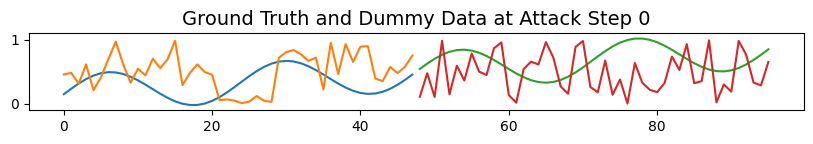

Starting attack for observation_days=2 with model TCN_Predictor


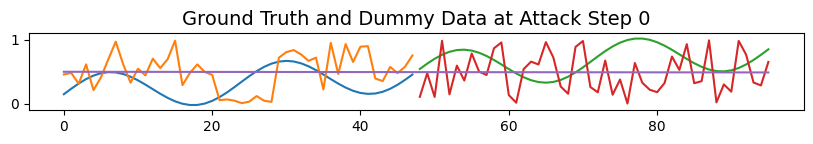

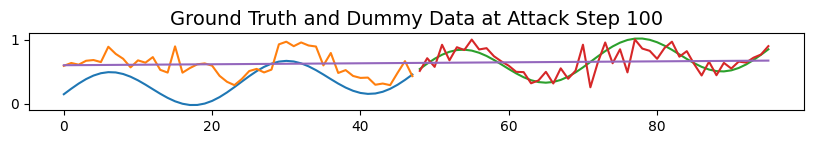

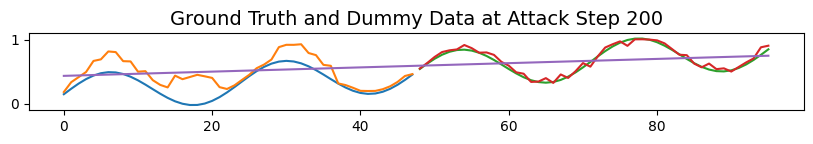

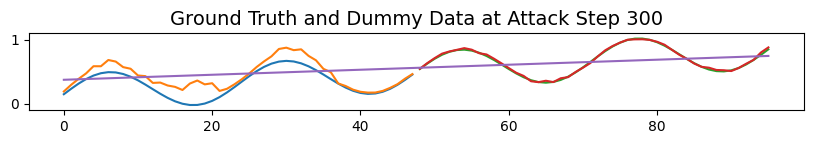

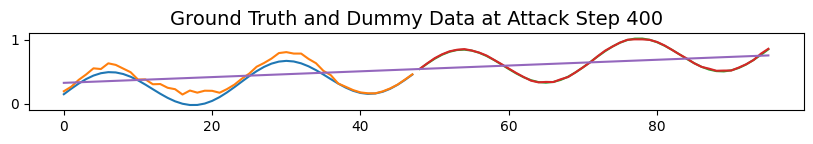

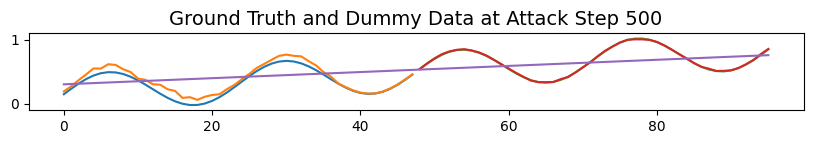

0.30989870429039 0.007962175644934177 6.5975189208984375


In [5]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

# train_loader = DataLoader(train_set, batch_size=(batch_size:=1), shuffle=False)
# Trend hyper-parameters
trend_value = 0.7
offset = 0.15
amplitude = 0.3
folder_path = "../out/00_tcn_experiments_trend"

png_files = glob.glob(os.path.join(folder_path, "*.png"))
# Delete each .png file
for file_path in png_files:
    try:
        os.remove(file_path)
    except OSError as e:
        print(f"Error deleting {file_path}: {e}")


# No trend hyper-parameters
# trend_value = 0.0
# offset = 0.5
# amplitude = 0.45
# folder_path = './out/00_tcn_experiments'


# Global hyper-parameters
cycles = 4
trend_regularization_term = 5e-1
dropout_term = 1e-6

input_data_based_on_observation_days = []
# for x, y in train_loader:
#     o_x, o_y = x[:, :, [0]], y[:, :, 0]
#     d_x, d_y = torch.rand_like(o_x), torch.rand_like(o_y)
#     input_data_based_on_observation_days.append((dataset_config['observation_days'], o_x, o_y, d_x, d_y))
#     break

for observation_days in [2]:
    t = torch.linspace(0, cycles * observation_days * np.pi, 24 * observation_days * 2)
    original_trend_series = torch.linspace(0, trend_value, 24 * observation_days * 2).unsqueeze(0).unsqueeze(-1)
    original_series = torch.sin(t).unsqueeze(0).unsqueeze(-1) * amplitude + offset

    original_series += original_trend_series

    original_x = original_series[:, : 24 * observation_days, :]
    original_y = original_series[:, 24 * observation_days :, 0]

    dummy_x, dummy_y = torch.rand_like(original_x), torch.rand_like(original_y)

    input_data_based_on_observation_days.append((observation_days, original_x.clone(), original_y.clone(), dummy_x.clone(), dummy_y.clone()))

    plot_original_and_dummy_data(dummy_x, dummy_y, original_x, original_y, attack_step=0)
    plt.show()


results_dictionary = {}
for observation_days, o_x, o_y, d_x, d_y in input_data_based_on_observation_days:
    original_x, original_y, dummy_x, dummy_y = o_x.clone(), o_y.clone(), d_x.clone(), d_y.clone()
    dummy_x.requires_grad_(True)
    dummy_y.requires_grad_(True)

    # model = FCN_Predictor(input_size=original_x.shape[1], output_size=original_y.shape[1], hidden_size=64)
    model = TCN_Predictor(
        features=[0], hidden_size=64, dilation_factor=2, kernel_size=6, input_size=original_x.shape[1], output_size=original_y.shape[1], dropout=0.1
    )
    original_out = model(original_x)
    original_y_loss = F.mse_loss(original_out, original_y)
    original_y_loss.backward()
    original_dy_dx = [param.grad.clone() for param in model.parameters()]

    optimization_space = [dummy_x, dummy_y]
    if "TCN" in model.name:
        dropout_masks = model.init_dropout_masks("cpu", "halves")
        optimization_space += dropout_masks

    dummy_optimizer = torch.optim.Adam(optimization_space, lr=0.005)

    print(f"Starting attack for observation_days={observation_days} with model {model.name}")
    for attack_step in range(600):

        def closure():
            dummy_optimizer.zero_grad()
            dummy_out = model(dummy_x)
            dummy_y_loss = F.mse_loss(dummy_out, dummy_y)
            dummy_dy_dx = torch.autograd.grad(dummy_y_loss, model.parameters(), create_graph=True)

            if (attack_step < 160 and attack_step % 3 == 0) or (attack_step >= 160 and attack_step % 10 == 0):
                fig, _ = plot_original_and_dummy_data(
                    dummy_x, dummy_y, original_x, original_y, plot_trend=trend_regularization_term > 0, attack_step=attack_step
                )
                # fig, _ = plot_original_and_dummy_data_and_gradients(dummy_x, dummy_y, original_x, original_y, dummy_dy_dx, original_dy_dx, attack_step, plot_trend=trend_regularization_term>0)
                fig.savefig(f"{folder_path}/attack_step_{attack_step}.png", bbox_inches="tight")
                plt.close()
                # plt.show()

            if attack_step % 100 == 0:
                fig, _ = plot_original_and_dummy_data(dummy_x, dummy_y, original_x, original_y, plot_trend=True, attack_step=attack_step)
                plt.show()

            dy_dx_loss = sum(F.l1_loss(d_g, o_g, reduction="sum") for d_g, o_g in zip(dummy_dy_dx, original_dy_dx))

            # if attack_step > 400:
            #     dy_dx_loss *= 100

            if "TCN" in model.name:
                for i, dropout_layer in enumerate(model.get_dropout_layers()):
                    dropout_loss = dropout_term * ((1 - dropout_layer.do_mask.mean()) - dropout_layer.p).abs()
                    dy_dx_loss += dropout_loss

            if trend_regularization_term > 0:
                combined_dummy_data_first_feature = torch.cat([dummy_x[:, :, 0], dummy_y[:, :]], dim=1)  # Same series
                dy_dx_loss += trend_regularization_term * trend_consistency_regularization(combined_dummy_data_first_feature, loss="l1_mean")

            dy_dx_loss.backward()
            return dy_dx_loss

        dy_dx_loss = dummy_optimizer.step(closure)

        if attack_step % 2 == 0:
            dummy_x.data.clamp_(0, 1)
            dummy_y.data.clamp_(0, 1)
            if "TCN" in model.name:
                model.clamp_dropout_layers()

    print(SMAPELoss(original_x, dummy_x).item(), SMAPELoss(original_y, dummy_y).item(), dy_dx_loss.item())

In [6]:
import datetime
import os
from PIL import Image


def make_gif_from_images(folder_path, output_filename, duration=500):
    files = os.listdir(folder_path)

    image_files = sorted([f for f in files if f.lower().endswith((".png", ".jpg", ".jpeg"))], key=lambda x: int("".join(filter(str.isdigit, x))))

    images = [Image.open(os.path.join(folder_path, file)) for file in image_files]

    images[0].save(os.path.join(folder_path, output_filename), save_all=True, append_images=images[1:], duration=duration, loop=0)

    for f in image_files:
        if f.lower().endswith(".png"):
            os.remove(os.path.join(folder_path, f))

    print(f"GIF saved as {output_filename} in {folder_path}")


output_filename = f"{datetime.datetime.now().strftime('%d-%H-%M')}_output_{trend_regularization_term}_{dropout_term}.gif"
make_gif_from_images(folder_path, output_filename, duration=75)

GIF saved as 28-13-37_output_0.5_1e-06.gif in ../out/00_tcn_experiments_trend
